In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import random
import seaborn as sns
import itertools
import os
from PIL import Image
import math
from matplotlib import gridspec
import matplotlib.collections

from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import matplotlib.collections

from sklearn.model_selection import *

from tqdm import *
# nice progress bars otherwise
# def tqdm(x):
#     yield x

In [2]:
# TODO, improvement ideas

# TPOT python auto ml
# use log(flux) as input
# investigate highest errors (argmax(xi²))

# kfold integration in place of CV
# TTA
# CNN segmentation cleanup 
# resnet v2 ( https://github.com/myutwo150/keras-inception-resnet-v2/blob/master/inception_resnet_v2.py )
# custom CNN features
# CV2 resize cubic interpolation 

# Serge:
# essayer de remplacer lgb par un Deep NN keras (vu la quantité de donnée)


#done
# lgbm eval rmsle instead of rmse
# add image size as feature



In [50]:
# memory debug function

import sys
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
mm = sorted([(x, sys.getsizeof(globals().get(x)),"{:,}".format(sys.getsizeof(globals().get(x)))) 
        for x in dir() 
           if not x.startswith('_') 
#         and x not in sys.modules
        and x not in ipython_vars], key=lambda x: x[1], reverse=True)

# mm

## data folder set up and test

In [4]:
dataFolder = 'data/mainData/'
plt.ion()

runNameParams = []
runNameParams.append('newSource')
# print(runNameParams)

In [5]:
def read_image(id):
    if id[-4:] == '.npy':
        X = np.load(dataFolder+id)
    elif os.path.isfile(dataFolder+id+'.npy'):
        X = np.load(dataFolder+id + '.npy')
    elif os.path.isfile(dataFolder+id+'-g.csv'):
        X = np.genfromtxt(dataFolder+id+'-g.csv', delimiter=",")
    else:
        X = None

    X = np.float32(X)
    return X


In [6]:
dataFileList = []

directory = os.fsencode(dataFolder)

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".npy") or filename.endswith(".py"): 
        dataFileList.append(filename)
        
print(len(dataFileList))

80306


# Check a few random images 


In [7]:
def drawOneGalaxy(galaxyID):
    oneImageData = read_image(galaxyID)
    print(galaxyID)

    # new image
    fig = plt.figure(figsize=(15,15))
    #set grid spec for the 4 graphs
    gs = gridspec.GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1,5]) 

    #draw image
    plt.title("raw")
    plt.subplot(gs[2])
    plt.imshow(oneImageData)
    
    # horizontal (top) sum
    plt.subplot(gs[0])
    plt.title(galaxyID)
    plt.plot(oneImageData.sum(axis=0))

    # vertical (bottom-right) sum
    ax = plt.subplot(gs[3])
    ss = np.flip(oneImageData.sum(axis=1),axis=0)
    plt.scatter(x=ss, y=list(range(oneImageData.shape[1])), s=1)
    lines = [[(ss[i-1],i-1),(ss[i],i)] for i in range(1,len(ss))]
    lc = matplotlib.collections.LineCollection(lines)
    ax.add_collection(lc)
    
    #value histogram
    plt.subplot(gs[1])
    plt.hist(oneImageData.reshape(-1), bins=100)
    plt.yscale('log')    
    sns.despine()
    plt.tight_layout()

    #add small log of image
    ax = fig.add_axes([0.02,0.6,.2,.2])
    plt.imshow(np.log(oneImageData-oneImageData.min()+0.00001))

for _ in range(5):
    i = random.randint(0,len(dataFileList))
#     oneImageData = np.load(dataFolder+'1237648704067273096.npy')
#     drawOneGalaxy(dataFileList[i])
    


In [8]:

issuesImages = ['1237658298983055529.npy','1237660634917634181.npy','1237654879654772871.npy','1237654953205170487.npy','1237651249884627014.npy','1237651754022207627.npy',
 '1237654669736018114.npy','1237655471824568727.npy','1237665530643808416.npy','1237658611444088911.npy','1237667255070490937.npy',
 '1237665531177795774.npy','1237645943975837722.npy','1237658425161220139.npy', '1237665129087435003.npy','1237657873792172224.npy',
 '1237660240313778264.npy','1237668298201432152.npy', '1237662264316264518.npy','1237657630042227294.npy','1237651754550624376.npy',
 '1237667211059986578.npy','1237655470208582145.npy']

# for image in issuesImages:
#     drawOneGalaxy(image)

In [9]:
print('test')

test


# ML part

In [10]:
import pandas as pd
import numpy as np
import cv2
from glob import glob
import xgboost as xgb
from keras.applications import *
import lightgbm as lgbm
import scipy
import tensorflow

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [11]:
def xi2(true,pred,error):
    s=np.mean((true-pred)**2/error**2)
    return s

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def normalizeND(A):
    A = (A - A.mean(axis=0)) / A.std(axis=0)
    return A

def normalize_image(Xg):
    Xg -= np.mean(Xg)
    Xg /= np.std(Xg)
    
    return Xg

def crop_image(Xg):
    h,w = Xg.shape
    cy, cx = h//2, w//2
    dy, dx = int(cy*0.75), int(cx*0.75) # crop a bit around center
    Xg = Xg[cy-dy:cy+dy,cx-dx:cx+dx]
    
    return Xg

def img_preprocnoread(Xg, preProcNum = 0):
#    Xg = cleanupImage(id)

    if ( preProcNum != 0):
        if preProcNum & 4: # rotate
            Xg = np.rot90(Xg)
            
        if preProcNum %4 == 1: # vflip
            Xg = np.flip(Xg,0)
        elif preProcNum %4 == 2: # hflip
            Xg = np.flip(Xg,1)
        elif preProcNum %4 == 3: # hflip+vflip
            Xg = np.flip(np.flip(Xg,1),0)

    Xg = np.log1p(Xg - Xg.min())
    Xg = normalize_image(Xg)
    Xg = crop_image(Xg)

    
    if Xg.shape[0] >= 224:
        Xgr = cv2.resize(Xg,(224,224), cv2.INTER_AREA)
    else:
        Xgr = cv2.resize(Xg,(224,224), cv2.INTER_CUBIC)
    
    return Xgr
    
def img_preproc(id, preProcNum = 0):
    Xg = read_image(id)
    return img_preprocnoread(Xg,preProcNum)

runNameParams.append('ReadLog1pNormCrop.75')
# preprocName = "ReadNormCrop.5"
# x = img_preproc('1237662637444694216')
x = img_preproc(dataFileList[random.randint(0,len(dataFileList))])


-1.91486 21.1179
[[-0.35844585 -0.55956852 -0.87458003 -0.98130959 -0.90654403]
 [-0.35030118 -0.48242021 -0.68935364 -0.82622802 -0.82011133]
 [-0.33754444 -0.36158544 -0.39924008 -0.5833292  -0.68473488]
 [-0.15009362 -0.15418856 -0.16060233 -0.32510993 -0.43693647]
 [-0.07971211 -0.07652189 -0.07152516 -0.12810756 -0.16705464]]


1

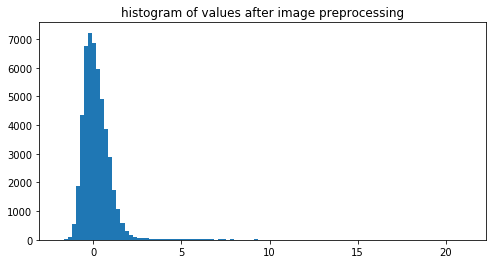

In [12]:
print(x.min(), x.max())
print(x[0:5,0:5])

plt.figure(figsize=(8,4))
plt.title('histogram of values after image preprocessing')
plt.hist(x.reshape(-1), bins=100)

1

### Load pretrained networks

### Read metadata file

In [13]:
df =  pd.read_fwf('metaData.dat', comment = '#')
df.columns = df.iloc[9,:].values
df = df[10:]
df.head()

,SDSS_ID,RA,DEC,D25,redshi,logMst,err_l,GalSize_kpc,D_Mpc,d_pix_kpc
10,1237662635825954925,210.95489999999998,12.64455,0.33113110693986714,0.1029,-99.0,-99.0,42.47806067869379,440.99999325616017,0.8552113203991983
11,1237652947452297303,0.84015,-9.98328,0.5248074948227709,0.0767,11.312,0.016,50.181626715917524,328.7142940929958,0.6374607478101917
12,1237652899137912944,1.0026,-11.17802,0.6165950323262803,0.0383,9.708,0.071,29.440699795795908,164.1428577048438,0.3183148122868964
13,1237661433779716229,211.48905000000002,43.88251,0.7585775667003197,0.0337,9.26,0.062,31.869792393005813,144.4285735487938,0.28008379359836033
14,1237652944786555077,1.48395,16.13445,0.3388441338170015,0.0909,10.7,0.04,38.39840364463448,389.571413397789,0.7554782039377076


In [14]:
df['RA'] = df['RA'].apply(np.float64)
df['DEC'] = df['DEC'].apply(np.float64)
df['D25'] = df['D25'].apply(np.float64)
df['redshi'] = df['redshi'].apply(np.float64)
df['logMstar'] = df['logMst'].apply(np.float64) #renamed
df['err_logMstar'] = df['err_l'].apply(np.float64) #renamed
df['GalSize_kpc'] = df['GalSize_kpc'].apply(np.float64)
df['Distance'] = df['D_Mpc'].apply(np.float64) #renamed
df['d_pix_kpc'] = df['d_pix_kpc'].apply(np.float64)

df['lin_mass'] = np.power(10, df.logMstar)
df['lin_err'] = df['lin_mass'] * np.log(10) * df.err_logMstar

df = df.drop(['logMst','err_l'], axis=1)
df.describe()

,RA,DEC,D25,redshi,GalSize_kpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err
count,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,1.877420e+05,1.877420e+05
mean,184.527190,24.898677,0.445798,0.074652,38.318105,0.620438,9.081941,-1.313631,319.936358,7.877701e+10,4.648110e+09
std,61.620064,19.374103,0.168006,0.040143,18.942158,0.333632,12.706553,11.469736,172.041273,9.461819e+10,5.529011e+09
min,0.008250,-11.252830,0.316228,0.010000,4.034125,0.083111,-99.000000,-99.000000,42.857142,1.000000e-99,-2.279559e-97
25%,152.349938,8.662358,0.346737,0.044100,25.157782,0.366519,10.191000,0.021000,189.000006,1.552387e+10,1.144774e+09
50%,185.824575,23.197910,0.389045,0.069000,35.525868,0.573465,10.693000,0.029000,295.714278,4.931738e+10,2.906879e+09
75%,222.151537,39.835143,0.478630,0.096400,48.283920,0.801189,11.032000,0.041000,413.142858,1.076465e+11,6.027530e+09
max,359.994900,70.133250,10.964781,0.299600,1373.931687,2.490003,12.326000,0.800000,1284.000022,2.118361e+12,1.727792e+11


In [15]:
# df.SDSS_ID[:20].apply(lambda x: x)
df['hasFile'] = df.SDSS_ID.apply(lambda x: os.path.isfile(dataFolder+x+'.npy'))

print("data file present:", len(df[df['hasFile']==True]))
print("data file missing:", len(df[df['hasFile']==False]))

data file present: 80306
data file missing: 107436


### Filter images that have no known mass, no actual image, or with an unknown error

In [16]:
df = df[df.logMstar != -99]
df = df[df.hasFile == True]
df = df[df['lin_err']!=0]

df = df[~df['SDSS_ID'].isin(['1237668349209149549','1237662224593846425'])] # remove 2 buggy galaxies

df.describe()

,RA,DEC,D25,redshi,GalSize_kpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err
count,78849.000000,78849.000000,78849.000000,78849.000000,78849.000000,78849.000000,78849.000000,78849.000000,78849.000000,7.884900e+04,7.884900e+04
mean,185.303801,25.672453,0.557628,0.058702,38.102040,0.487874,10.558196,0.031070,251.578038,7.898349e+10,4.399002e+09
std,57.112144,18.944952,0.194412,0.032566,19.838525,0.270663,0.654462,0.016953,139.570710,9.624207e+10,5.552778e+09
min,0.009450,-11.238420,0.407380,0.010000,5.248929,0.083111,7.376000,0.001000,42.857142,2.376840e+07,4.756699e+05
25%,154.485750,9.795100,0.436516,0.033800,24.390653,0.280915,10.200000,0.019000,144.857136,1.584893e+10,1.023221e+09
50%,186.753000,24.400580,0.489779,0.052300,35.043089,0.434670,10.692000,0.028000,224.142852,4.920395e+10,2.693666e+09
75%,221.980200,40.094130,0.602560,0.075600,47.500516,0.628319,11.030000,0.039000,323.999992,1.071519e+11,5.603185e+09
max,359.994900,70.133250,10.964781,0.294800,1373.931687,2.450110,12.326000,0.778000,1263.428628,2.118361e+12,1.414535e+11


In [17]:
random.seed(42)

# df = df.sample(frac=1).reset_index(drop=True)

In [18]:
df.head()

,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err,hasFile
184,1237662301367173202,231.31860,41.34601,0.512861,0.0761,48.655727,326.14285392420635,0.632474,10.325,0.045,326.142854,2.113489e+10,2.189920e+09,True
226,1237662301905813735,236.00985,39.28830,0.446684,0.0685,38.145197,293.5714168207986,0.569310,9.824,0.040,293.571417,6.668068e+09,6.141517e+08,True
247,1237662534360301834,237.49500,9.27861,0.630957,0.0390,30.677076,167.1428605914116,0.324133,9.923,0.053,167.142861,8.375293e+09,1.022096e+09,True
286,1237662500543987740,242.00880,36.05398,0.562341,0.0658,46.129129,282.0000158888953,0.546870,10.356,0.079,282.000016,2.269865e+10,4.128980e+09,True
342,1237662474232398001,246.28905,29.94774,0.446684,0.0455,25.337321,194.9999960405486,0.378155,9.234,0.094,194.999996,1.713957e+09,3.709741e+08,True


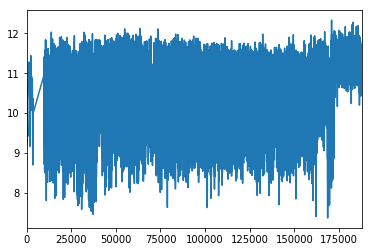

In [19]:
df.logMstar.plot()

In [20]:
print(len(df.SDSS_ID.values))

78849


In [21]:
# crap instruction to make the auto execution stop here :p

### call img_preproc on all images, per batches of "chunkSize"
### Generate features based on the preprocessed images, pretrained networks and flux densities

In [22]:
def chunkFileName(chunkSize, prefix, chunkNumber):
    fileName = 'Xg3-'+str(chunkSize)+'-'+prefix+'-chunk-' + str(chunkNumber) + '.npy'
    return fileName

In [23]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'nthread': 4,
    #'silent': True,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'max_depth': 10,
    'max_bin': 255,
    #'subsample_for_bin': 50000,
    #'subsample': 0.8,
    #'subsample_freq': 1,
    #'colsample_bytree': 0.8,
    #'reg_alpha': 1,
    #'reg_lambda': 0,
    #'min_split_gain': 0.5,
    #'min_child_weight': 1,
    #'min_child_samples': 60,
    #'scale_pos_weight': 1,
    'device' : 'gpu',
    'metric' : 'rmse',
    #'metric' : 'multi_error',
    'verbose':0,          
}

In [24]:
vgg16 = None
r50 = None

In [25]:
postImgFeatureNames = ['norm.flux.sum', 'norm.flux.min',
                       'norm.flux.max', 'norm.flux.mean', 
                       'norm.flux.std', 'center.flux', 
                       'aroundCenter.flux']
preImgFeatureNames = ['pre.flux.sum', 'pre.flux.min', 
                      'pre.flux.max', 'pre.flux.mean',
                      'pre.flux.std', 'pre.center.flux',
                      'pre.aroundCenter.flux', 'width']
distanceNames = ['D', '1/D', 'D**2', '1/D**2', 'D**3', '1/D**3', 'log(D)', '1/log(D)', 'log(D**2)', 'log(1/D**2)', 'log(D)**2', '1/log(D)**2' ]


def getFeatures(preProcessingNum):
    global vgg16, r50
    
    if vgg16 == None:
        vgg16 = VGG16(weights='imagenet',include_top=True,input_shape=(224,224,3))
    if r50 == None:
        r50 = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))

    Xg3r50 = []
    Xg3vgg16 = []
    postImgFeatures = []
    csize=2
    preImgFeatures = []

    maxChunkNumber = math.ceil(len(ids)/chunkSize)
    chunkStart = 0
    # for chunkStart in tqdm(range(0, 3)):
    
    # do the loading by chunk to avoid consuming too much memory
    for chunkStart in tqdm(range(0, len(ids), chunkSize)):
        curChunk = int((chunkStart//chunkSize))
        valuesInThisChunk = min(chunkStart+chunkSize,len(ids))-chunkStart

        Xg_ = []
        pre_ex_ = []

        # preprocess the image and collect some raw image stats
        for i in range(chunkStart, chunkStart+valuesInThisChunk):
            X = read_image(ids[i])
            Xg_.append(img_preprocnoread(X, preProcessingNum))
            pre_ex_.append([
                X.sum(),
                X.min(),
                X.max(),
                X.mean(),
                X.std(),
                X[X.shape[0]//2,X.shape[1]//2],
                np.mean(X[X.shape[0]//2-csize:X.shape[0]//2+csize,X.shape[1]//2-csize:X.shape[1]//2+csize]), # mean center
                X.shape[0], 
            ])

        # reformat the postprocessing
        pre_ex = np.stack(pre_ex_)
        Xg = np.stack(Xg_)

        # collect some post processing stats
        post_ex = np.hstack([
            np.sum(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.min(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.max(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.mean(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.std(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            Xg[:,112,112].reshape(valuesInThisChunk,1),       # center
            np.mean(Xg[:,112-csize:112+csize,112-csize:112+csize].reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,-1) # mean center
            ])

        # prepare correct dimension to feed to imagenet networks
        Xg3 = np.zeros((valuesInThisChunk,224,224,3))
        Xg3[:,:,:,:] = Xg.reshape(valuesInThisChunk,224,224,1)

        # do r50 prediction
        Xg3r50_ = r50.predict(Xg3).reshape(valuesInThisChunk, 2048)
        Xg3vgg16_ = vgg16.predict(Xg3)


        if chunkStart == 0:
            Xg3r50 = Xg3r50_
            Xg3vgg16 = Xg3vgg16_
            preImgFeatures = pre_ex
            postImgFeatures = post_ex
        else:
            Xg3r50 = np.concatenate([Xg3r50,Xg3r50_], axis=0)
            Xg3vgg16 = np.concatenate([Xg3vgg16,Xg3vgg16_], axis=0)
            preImgFeatures = np.concatenate([preImgFeatures,pre_ex], axis=0)
            postImgFeatures = np.concatenate([postImgFeatures,post_ex], axis=0)



    # add features from the data itself (distance)
    Distance = df.Distance.values[:N].reshape(N,1)

    Xg3f = np.hstack ( ( 
            Xg3r50, 
            Xg3vgg16, 
            Distance,
            1/Distance,
            Distance**2,
            1/(Distance**2),
            Distance**3,
            1/(Distance**3),
            np.log(Distance),
            1/np.log(Distance),
            np.log(Distance**2),
            1/np.log(Distance**2),
            np.log(Distance)**2,
            1/np.log(Distance)**2,
            preImgFeatures,
            postImgFeatures
            ) )


    Xg3fNames = ( [prefixThisRound+'.r50.' + str(i) for i in range(Xg3r50.shape[1])]
                + [prefixThisRound+'.vgg16.' + str(i) for i in range(Xg3vgg16.shape[1])] 
                + [prefixThisRound+'.'+ n for n in distanceNames]
                + [prefixThisRound+'.'+ n for n in preImgFeatureNames]
                + [prefixThisRound+'.'+ n for n in postImgFeatureNames])

#     print(len(Xg3fNames), Xg3f.shape)
    
    return Xg3f, Xg3fNames

numFeatures = 2048 + 1000 + len(postImgFeatureNames) + len(preImgFeatureNames) + len(distanceNames)
    

In [26]:
def getLGBMModelsWithCV(trainSet, YSet):
    kf = KFold(n_splits=nSplits,shuffle=True, random_state=220477)

    cvtrainpreds = np.zeros([len(Xg3f),nSplits])
    models = []
    xis, linxis = [],[]
    counter = 0
    for tix, vix in kf.split(trainSet):
        X_train, X_test = trainSet[tix], trainSet[vix]
        Y_train, Y_test = YSet[tix], YSet[vix]

        lgb_train = lgbm.Dataset(X_train, Y_train)
        lgb_eval = lgbm.Dataset(X_test, Y_test)

        gbm = lgbm.train(lgbm_params,
                           lgb_train,
                           num_boost_round=maxBoostRuns,
                           valid_sets=[lgb_train,lgb_eval],  # eval training data
                           verbose_eval=100,
                           early_stopping_rounds=100
                        )
        models.append(gbm)

        p = gbm.predict(X_test)
        chiSq = xi2(Y_test,p,err[vix])
        linChiSq = xi2(10**Y_test,10**p,err_lin[vix])
        xis.append(chiSq)
        linxis.append(linChiSq)
        print(counter,chiSq,linChiSq)    

        cvtrainpreds[vix,counter] = p
        counter = counter+1
        
    return models, cvtrainpreds, xis, linxis

# models, cvtrainpreds, xis, linxis = getModels(Xg3f[:M], Y[:M])

# print(models, cvtrainpreds)

# print(xis, linxis)


In [27]:
def getLGBMModelsNoCV(trainSet, YSet, errSet, errlinSet):
    cvtrainpreds = np.zeros([len(trainSet),1])
    models = []
    xis, linxis = [],[]
    counter = 0

    tix, vix = list(range(0,int(len(trainSet)*0.9))), list(range(int(len(trainSet)*0.9),len(trainSet)))
    
    X_train, X_test = trainSet[tix], trainSet[vix]
    Y_train, Y_test = YSet[tix], YSet[vix]

    lgb_train = lgbm.Dataset(X_train, Y_train)
    lgb_eval = lgbm.Dataset(X_test, Y_test)

    gbm = lgbm.train(lgbm_params,
                       lgb_train,
                       num_boost_round=maxBoostRuns,
                       valid_sets=[lgb_train,lgb_eval],  # eval training data
                       verbose_eval=100,
                       early_stopping_rounds=200
                    )
    models.append(gbm)

    p = gbm.predict(X_test)
    r = rmse(p,Y_test)
    print(r)
    chiSq = xi2(Y_test,p,errSet[vix])
    linChiSq = xi2(10**Y_test,10**p,errlinSet[vix])
    xis.append(chiSq)
    linxis.append(linChiSq)
    print(counter,chiSq,linChiSq)    

    cvtrainpreds[vix,counter] = p
    counter = counter+1
        
    return models, cvtrainpreds, xis, linxis


In [28]:
# from keras.models import model9d

# def get9DModel(trainSet, YSet):
#     model = model9d(trainSet.shape[1])
#     model.fit(trainSet,YSet,verbose=1)
#     return model

In [29]:
TRAIN = 0
TEST = 4
FEATURES = 0
TRUTH = 1
ERROR = 2
LINERROR = 3
ID = 8
FEATURENAMES = 9

data = list(range(10))


# Iteration parameters defined here:

- N is the number of galaxies to use for this run
- M is the number of galaxies to train set (rest is holdout)
- chunkSize is the number of galaxies to evaluate at once
- prefixThisRound is the model name, for serialization purposes

In [30]:
df = df.sample(frac=1)

In [31]:
N = int(len(df.SDSS_ID.values))
M = int(N*.9)

prefixThisRound = 'sp'
for i in runNameParams:
    prefixThisRound = prefixThisRound + '-' + i

prefixThisRound = prefixThisRound + '-model9'
    
chunkSize = 200
# nSplits = 3
reloadImagesAndPreprocess = 1
numPreprocessing = 1
nSplits = 1

maxBoostRuns = 30000 # 30000
# N = 3000 # number of galaxies to take into consideration
# M = 2000 # train vs holdout


# N = int(N*0.1)
# M = int(M*0.1)


In [32]:
ids = df.SDSS_ID.values[:N]
Y = df.logMstar.values[:N]
err = df.err_logMstar.values[:N]
Y_lin = df.lin_mass.values[:N]
err_lin = df.lin_err.values[:N]

In [33]:
print(N)
print(M)
print(chunkSize)
print(prefixThisRound)

78849
70964
200
sp-newSource-ReadLog1pNormCrop.75-model9


In [34]:
ttaPredictions = np.zeros([numPreprocessing,nSplits,N-M])


data[TRAIN+FEATURES] = np.ones([0,numFeatures])
data[TRAIN+TRUTH] = np.ones([0])
data[TRAIN+ERROR] = np.ones([0])
data[TRAIN+LINERROR] = np.ones([0])
data[TEST+FEATURES] = np.ones([0,numFeatures])
data[TEST+TRUTH] = np.ones([0])
data[TEST+ERROR] = np.ones([0])
data[TEST+LINERROR] = np.ones([0])

fileName = prefixThisRound + '-' + str(N) + 'allFeatures' + str(numPreprocessing) + '.npy'

data[ID] = ids

if reloadImagesAndPreprocess == 1 or not(os.path.isfile(fileName)):
    for curTTA in range(numPreprocessing):
        a, Xg3fNames = getFeatures(curTTA)
        a = normalizeND(a)

        data[TRAIN+FEATURES] = np.vstack([data[TRAIN+FEATURES],a[:M]])
        data[TRAIN+TRUTH] = np.hstack([data[TRAIN+TRUTH],Y[:M]])
        data[TRAIN+ERROR] = np.hstack([data[TRAIN+ERROR],err[:M]])
        data[TRAIN+LINERROR] = np.hstack([data[TRAIN+LINERROR], err_lin[:M]])

        data[TEST+FEATURES] = np.vstack([data[TEST+FEATURES],a[M:]])
        data[TEST+TRUTH] = np.hstack([data[TEST+TRUTH],Y[M:]])
        data[TEST+ERROR] = np.hstack([data[TEST+ERROR],err[M:]])
        data[TEST+LINERROR]  = np.hstack([data[TEST+LINERROR] , err_lin[M:]])

    np.save(fileName, data)
else:
    data = np.load(fileName)


print("loaded")

100%|██████████| 395/395 [11:55<00:00,  1.63s/it]


loaded


In [35]:
# data.append(Xg3fNames)
# print(len(data))
# np.save(fileName, data)

In [36]:
models, cvtrainpreds, xis, linxis = getLGBMModelsNoCV(data[TRAIN+FEATURES], data[TRAIN+TRUTH], data[TRAIN+ERROR], data[TRAIN+LINERROR])

ppreds = np.zeros([len(models),data[TEST+FEATURES].shape[0]])
for i, m in zip(range(len(models)),models):
    mp = m.predict(data[TEST+FEATURES])
    ppreds[i] = mp

cvpred = ppreds.mean(axis=0)

Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 0.355816	valid_1's rmse: 0.363333
[200]	training's rmse: 0.258881	valid_1's rmse: 0.267372
[300]	training's rmse: 0.226628	valid_1's rmse: 0.235376
[400]	training's rmse: 0.212522	valid_1's rmse: 0.221756
[500]	training's rmse: 0.203953	valid_1's rmse: 0.213817
[600]	training's rmse: 0.197761	valid_1's rmse: 0.208282
[700]	training's rmse: 0.192917	valid_1's rmse: 0.204155
[800]	training's rmse: 0.189057	valid_1's rmse: 0.20116
[900]	training's rmse: 0.185751	valid_1's rmse: 0.198748
[1000]	training's rmse: 0.18297	valid_1's rmse: 0.196819
[1100]	training's rmse: 0.180526	valid_1's rmse: 0.19527
[1200]	training's rmse: 0.178356	valid_1's rmse: 0.193963
[1300]	training's rmse: 0.176373	valid_1's rmse: 0.192898
[1400]	training's rmse: 0.174573	valid_1's rmse: 0.191981
[1500]	training's rmse: 0.172894	valid_1's rmse: 0.191166
[1600]	training's rmse: 0.171324	valid_1's rmse: 0.190445
[1700]	training's rms

[14200]	training's rmse: 0.0979271	valid_1's rmse: 0.179284
[14300]	training's rmse: 0.0975952	valid_1's rmse: 0.179278
[14400]	training's rmse: 0.0972707	valid_1's rmse: 0.179277
[14500]	training's rmse: 0.0969329	valid_1's rmse: 0.179264
[14600]	training's rmse: 0.0966036	valid_1's rmse: 0.179246
[14700]	training's rmse: 0.0962778	valid_1's rmse: 0.17923
[14800]	training's rmse: 0.0959606	valid_1's rmse: 0.179216
[14900]	training's rmse: 0.0956379	valid_1's rmse: 0.179201
[15000]	training's rmse: 0.0953218	valid_1's rmse: 0.179198
[15100]	training's rmse: 0.0949991	valid_1's rmse: 0.179195
[15200]	training's rmse: 0.0946702	valid_1's rmse: 0.179181
[15300]	training's rmse: 0.0943504	valid_1's rmse: 0.179168
[15400]	training's rmse: 0.0940413	valid_1's rmse: 0.179168
[15500]	training's rmse: 0.0937118	valid_1's rmse: 0.179151
[15600]	training's rmse: 0.0933989	valid_1's rmse: 0.179142
[15700]	training's rmse: 0.0930788	valid_1's rmse: 0.179135
[15800]	training's rmse: 0.0927743	valid_

In [37]:
print("Iteration : {}".format(numPreprocessing))
print("rmse of log(M):",rmse(data[TEST+TRUTH],cvpred))

# ttaPredictions[curTTA] = ppreds
    

Iteration : 1
rmse of log(M): 0.178046145877


In [38]:
ppreds.reshape((numPreprocessing,-1)).mean(axis=0)

array([ 10.97266823,  11.43704172,  11.3374867 , ...,  10.96935824,
        10.82992232,  10.87578205])

In [39]:
# print(M)
# print(trainXg3fStacked.shape)
# testXg3fStacked.shape
# ttaPredictions.shape
# ppreds.shape

mpred = ppreds.reshape((numPreprocessing,-1)).mean(axis=0)
print("Iteration : {}".format(numPreprocessing))
print("rmse of log(M):",rmse(data[TEST+TRUTH],mpred))


Iteration : 1
rmse of log(M): 0.178046145877


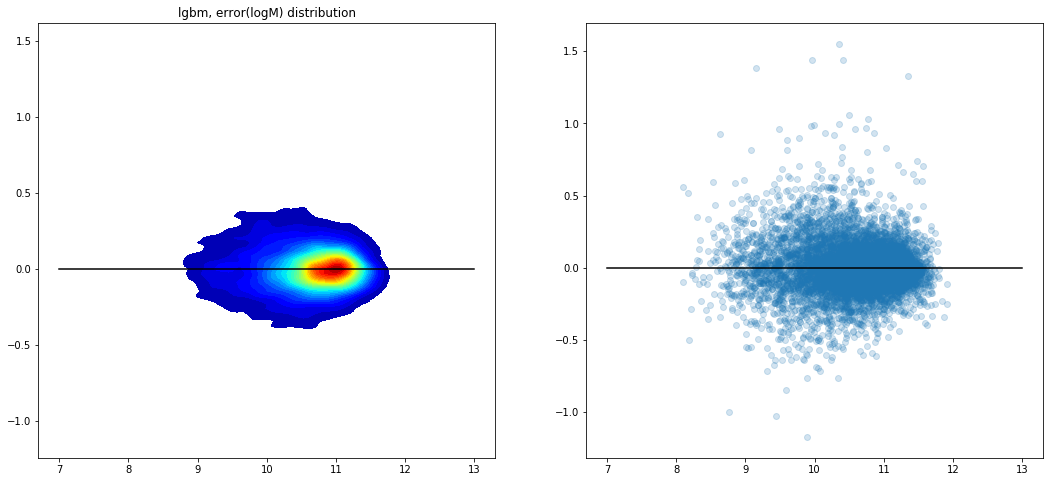

In [40]:
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.title('lgbm, error(logM) distribution')
sns.kdeplot(mpred, mpred-data[TEST+TRUTH],n_levels=30, shade=True, shade_lowest=False, cmap='jet')
plt.plot([7,13],[0,0], 'k-')
plt.subplot(122)
plt.scatter(x=mpred, y=mpred-data[TEST+TRUTH], alpha=0.2)
plt.plot([7,13],[0,0], 'k-')


In [41]:
import keras


In [75]:
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    epochsPerDraw = 10
#     referencePrediction = None
    
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = [] # self validation
        self.testrmse = [] # external validation
        
        self.fig = plt.figure()
        
        self.logs = []
        self.referenceRMSE = rmse(self.referencePrediction, data[TEST+TRUTH])

    def on_epoch_end(self, epoch, logs={}):
        
        self.i += 1
        
        if ( self.i %self.epochsPerDraw != 0 ):
            return

        self.logs.append(logs)
        self.x.append(self.i)
        curloss = logs.get('loss')
        curloss = math.sqrt(curloss)
        self.losses.append(curloss)
        self.val_losses.append(math.sqrt(logs.get('val_loss')))
        
        clear_output(wait=True)

        plt.figure(figsize=(16,8))
        plt.suptitle("{}/{} {} {}".format(self.i,numEpochs,curloss, prefixThisRound))

        
        plt.subplot(131) # self values
        plt.ylabel('error(log(M))')
        plt.xlabel('true log(M)')

        pred = model.predict(data[TRAIN+FEATURES]).clip(7,13)[:,0]
        r = rmse(pred,data[TRAIN+TRUTH])
        plt.scatter(x=data[TRAIN+TRUTH], y=pred-data[TRAIN+TRUTH], c='r', alpha=.1, label="NN train {:02f}".format(r))
        plt.plot([7, 13], [0,0], 'k-', lw=2, label="target")
        axes = plt.gca()
        axes.set_xlim([7,13])
#         axes.set_ylim([7,13])
        plt.legend()


        plt.subplot(132)
        plt.ylabel('error(log(M))')
        plt.xlabel('true log(M)')
        
        # lgbm values
        plt.scatter(x=data[TEST+TRUTH], y=self.referencePrediction-data[TEST+TRUTH], c='b', alpha=.1, label="ref {:02f}".format(self.referenceRMSE))
        
        # test values
        pred = model.predict(data[TEST+FEATURES]).clip(7,13)[:,0]
#         print(pred.shape)
        r = rmse(data[TEST+TRUTH],pred)
        self.testrmse.append(r)
        plt.scatter(x=data[TEST+TRUTH], y=pred-data[TEST+TRUTH], c='g', alpha=.1, label="NN test {:02f}".format(r))
        
        plt.plot([7, 13], [0, 0], 'k-', lw=2, label="target")
        axes = plt.gca()
        axes.set_xlim([7,13])
#         axes.set_ylim([7,13])
        plt.legend()
    
    
        ax = plt.subplot(133)
        plt.plot(self.x, self.losses, label="self RMSE")
        plt.plot(self.x, self.val_losses, label="val RMSE")
#         ax2 = ax.twinx()
        ax.set_yscale("log", nonposy='clip')
#         ax2.set_yscale("log", nonposy='clip')
        plt.plot(self.x, self.testrmse, label="test rmse", c='g')
        ax.axhline(self.referenceRMSE,linestyle='--')
        plt.legend()
        
#         plt.tight_layout()
        
        plt.savefig("pltsave/" + prefixThisRound + "%05d.png" % self.i)
#         plt.savefig("pltsave/test%03d.png" % self.i)
        plt.show();
#         print(x)
        
plot_losses = PlotLosses()

In [43]:
import models


In [44]:
numEpochs = 30000
plot_losses.epochsPerDraw = 50
plot_losses.referencePrediction = mpred
# num = 33020
num = N

m9d = models.model9d(data[TRAIN+FEATURES].shape[1])

m9d.fit(data[TRAIN+FEATURES][:num,:], data[TRAIN+TRUTH][:num], batch_size=10000, epochs=numEpochs, validation_split = 0.1, verbose = 1, callbacks=[plot_losses])


/var/projects/astrohack/models.py:18: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  x = merge([x, input_tensor], mode='sum', concat_axis=1)
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/var/projects/astrohack/models.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("x2..., outputs=Tensor("ou...)`
  model = Model(input=in2, output=out)


Train on 63867 samples, validate on 7097 samples
Epoch 1/30000


ResourceExhaustedError: OOM when allocating tensor with shape[10000,4096]
	 [[Node: leaky_re_lu_8/Neg = Neg[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](batch_normalization_5/cond/Merge)]]
	 [[Node: mul_1/_1561 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_4610_mul_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'leaky_re_lu_8/Neg', defined at:
  File "/opt/anaconda3/envs/astrohack/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/anaconda3/envs/astrohack/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-44-f09e9ab313a6>", line 7, in <module>
    m9d = models.model9d(data[TRAIN+FEATURES].shape[1])
  File "/var/projects/astrohack/models.py", line 31, in model9d
    x = fc_identity(x, n, d=0.5)
  File "/var/projects/astrohack/models.py", line 16, in fc_identity
    x = fc_block1(input_tensor, n, d)
  File "/var/projects/astrohack/models.py", line 11, in fc_block1
    x = LeakyReLU()(x)
  File "/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/keras/engine/topology.py", line 596, in __call__
    output = self.call(inputs, **kwargs)
  File "/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/keras/layers/advanced_activations.py", line 41, in call
    return K.relu(inputs, alpha=self.alpha)
  File "/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2662, in relu
    negative_part = tf.nn.relu(-x)
  File "/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2759, in _neg
    "Neg", x=x, name=name)
  File "/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2938, in create_op
    op_def=op_def)
  File "/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1466, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[10000,4096]
	 [[Node: leaky_re_lu_8/Neg = Neg[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](batch_normalization_5/cond/Merge)]]
	 [[Node: mul_1/_1561 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_4610_mul_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


0.192918266205


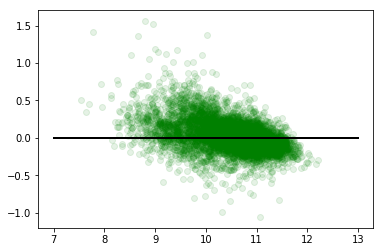

In [69]:
pred = model.predict(data[TEST+FEATURES]).clip(7,13)[:,0]
r = rmse(data[TEST+TRUTH],pred)
plt.scatter(x=data[TEST+TRUTH], y=pred-data[TEST+TRUTH], c='g', alpha=.1, label="NN test {:02f}".format(r))

plt.plot([7, 13], [0, 0], 'k-', lw=2, label="target")
print(r)

In [45]:
m9d = None

In [51]:
print(data[TRAIN+FEATURES].shape)
print(data[TRAIN+TRUTH].shape)

(70964, 3075)
(70964,)


In [54]:
print(set(np.argwhere(np.isnan(data[TRAIN+FEATURES]))[:,1]))
print(set(np.argwhere(np.isnan(data[TEST+FEATURES]))[:,1]))

set()
set()


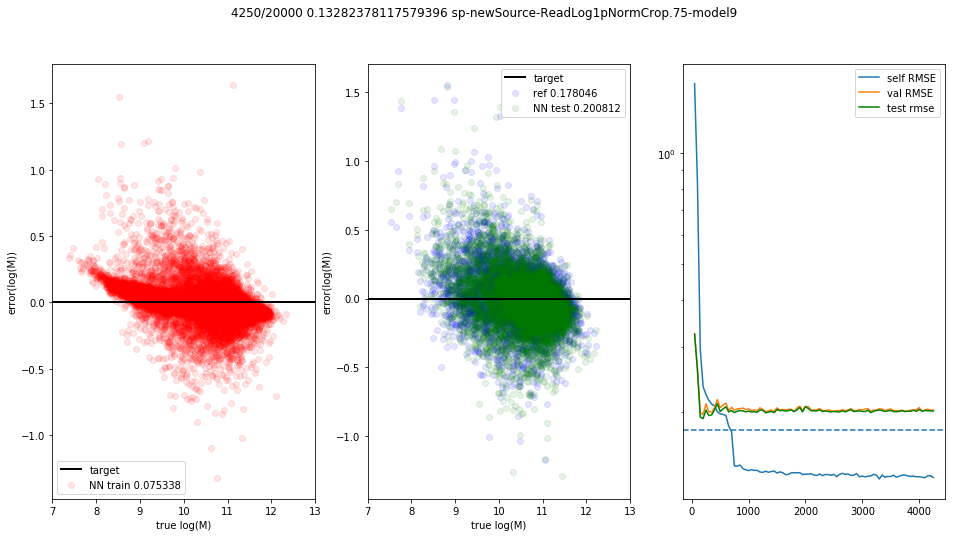

63867/63867 [==============================] - 4s - loss: 0.0176 - acc: 0.0013 - val_loss: 0.0408 - val_acc: 9.8633e-04
Epoch 4251/20000
63867/63867 [==============================] - 0s - loss: 0.0179 - acc: 0.0012 - val_loss: 0.0414 - val_acc: 9.8633e-04
Epoch 4252/20000
63867/63867 [==============================] - 0s - loss: 0.0180 - acc: 0.0013 - val_loss: 0.0408 - val_acc: 9.8633e-04
Epoch 4253/20000
63867/63867 [==============================] - 0s - loss: 0.0179 - acc: 0.0013 - val_loss: 0.0405 - val_acc: 9.8633e-04
Epoch 4254/20000
63867/63867 [==============================] - 0s - loss: 0.0185 - acc: 0.0013 - val_loss: 0.0405 - val_acc: 9.8633e-04
Epoch 4255/20000
63867/63867 [==============================] - 0s - loss: 0.0173 - acc: 0.0013 - val_loss: 0.0404 - val_acc: 9.8633e-04
Epoch 4256/20000
63867/63867 [==============================] - 0s - loss: 0.0176 - acc: 0.0013 - val_loss: 0.0415 - val_acc: 9.8633e-04
Epoch 4257/20000
63867/63867 [============================

KeyboardInterrupt: 

In [76]:
# test keras model
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras.optimizers import *

model = Sequential()

model.add(Dense(500, input_shape=(data[TRAIN+FEATURES].shape[1],), activation = 'relu', kernel_initializer='truncated_normal',))
# model.add(Dropout(0.5))

model.add(Dense(300, activation='relu',kernel_initializer='truncated_normal',))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu',kernel_initializer='truncated_normal',))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='elu',kernel_initializer='truncated_normal'))

model.compile(optimizer='nadam', loss='mse', metrics=['accuracy'])


# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# model.compile(optimizer=RMSprop(lr=1e-4, decay=1e-6),loss='mse',metrics=['accuracy'])
# model.compile(optimizer='adagrad',loss='mse',metrics=['accuracy'])
# model.compile(optimizer=sgd,loss='mse',metrics=['accuracy'])


numEpochs = 20000
plot_losses.epochsPerDraw = 50
plot_losses.referencePrediction = mpred
# num = 5000
num = N

model.fit(data[TRAIN+FEATURES][:num,:], data[TRAIN+TRUTH][:num], batch_size=1000, epochs=numEpochs, validation_split = 0.1, verbose = 1, callbacks=[plot_losses])



x = model.predict(data[TEST+FEATURES])
print(x)

linChiSq = xi2(10**data[TEST+TRUTH],10**x,data[TEST+LINERROR])
print(linChiSq)

g = sns.jointplot(x=cvpred, y=data[TEST+TRUTH], alpha=.3)
g.x = x[:,0].clip(7,13)
g.y = data[TEST+TRUTH]
g.plot_joint(plt.scatter, alpha=.3, c='r')
plt.suptitle('dataSize:{} epochs:{}'.format(num,numEpochs))

plt.legend(['lgbm', 'keras-rmsprop'])
# sns.jointplot(x=x[:,0], y=cvpred)


In [84]:
# model.save(prefixThisRound + "." + str(numEpochs) + ".h5" )



x = model.predict(data[TEST+FEATURES])[:,0]
print(rmse(x,data[TEST+TRUTH]))

0.199749985983


In [83]:
x.reshape(-1).shape

(7885,)

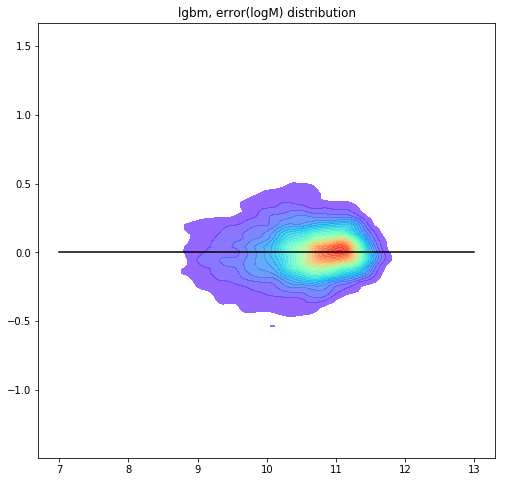

In [91]:
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.title('lgbm, error(logM) distribution')
# plt.scatter(x=mpred, y=mpred-data[TEST+TRUTH], alpha=0.2, c='k')
sns.kdeplot(x, x-data[TEST+TRUTH],n_levels=30, shade=True, shade_lowest=False, cmap='rainbow', alpha=0.7)
plt.plot([7,13],[0,0], 'k-')

In [ ]:
videoSaveCmd = "ffmpeg -framerate 20 -i pltsave/" + prefixThisRound + "%05d.png -r " + str(numEpochs) + " -pix_fmt yuv420p pltsave/" + prefixThisRound + str(numEpochs) +"-" +str(num) + ".mp4"
print(videoSaveCmd + " && rm pltsave/*.png")

In [ ]:

print(x.shape)
print(mpred.shape)
print(data[TEST+TRUTH].shape)
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.title('lgbm, log(error) distribution')
sns.kdeplot(mpred, mpred-data[TEST+TRUTH],n_levels=30, shade=True, shade_lowest=False, cmap='jet')
plt.plot([7,13],[0,0], 'k-')
plt.subplot(122)
plt.scatter(x=mpred, y=mpred-data[TEST+TRUTH], alpha=0.2)
plt.plot([7,13],[0,0], 'k-')

plt.figure(figsize=(18,8))
plt.subplot(121)
plt.title('NN1, log(error) distribution')
sns.kdeplot(x.clip(7,13)[:,0], x.clip(7,13)[:,0]-data[TEST+TRUTH],n_levels=30, shade=True, shade_lowest=False, cmap='jet')
plt.plot([7,13],[0,0], 'k-')
plt.subplot(122)
plt.scatter(x=x.clip(7,13), y=x.clip(7,13)[:,0]-data[TEST+TRUTH], alpha=0.2)
plt.plot([7,13],[0,0], 'k-')


plt.figure(figsize=(18,8))
plt.title('lgbm, log(error) distribution')
plt.scatter(x=mpred, y=mpred-data[TEST+TRUTH], alpha=0.2)
sns.kdeplot(mpred, mpred-data[TEST+TRUTH],n_levels=30, shade=True, shade_lowest=False, cmap='jet', alpha=0.6)
plt.plot([7,13],[0,0], 'k-')
plt.subplot(122)


In [ ]:
tpot.export('tpot_hackaton_pipeline.py')


In [ ]:
from tpot import TPOTRegressor
# from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2)
tpot.fit(data[TRAIN+FEATURES], data[TRAIN+TRUTH])
print(tpot.score(data[TEST+FEATURES], data[TEST+TRUTH]))
tpot.export('tpot_hackaton_pipeline.py')


In [ ]:
print(np.argwhere(np.isnan(data[TEST+FEATURES])))

# print(Xg3fNames[3048:])

# print(data[TEST+FEATURES][2602][3048:])
print(data[TEST+TRUTH][2602])


print(df[df.logMstar == 10.289 ])
xxx
# df.columns 164.571436388

# drawOneGalaxy('1237668349209149549')
drawOneGalaxy('1237662224593846425')